In [1]:
# load modules
import os
import numpy as np
import pandas as pd
import pickle

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import palantir
import scanpy.api as sc
sc.settings.verbosity = 5

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import random
random.seed(100)

In [3]:
%matplotlib inline

## Download data

Anndata objects with all the data and metadata are publically avaiable at: https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep[1-3].h5ad. This notebook use replicate 1 (https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep1.h5ad) for illustration. 

Description of the anndata object is available at https://s3.amazonaws.com/dp-lab-data-public/palantir/readme

## Load data

In [4]:
# Load the AnnData object
ad = sc.read('annadata/human_cd34_bm_rep1.h5ad')
colors = pd.Series(ad.uns['cluster_colors'])
ct_colors = pd.Series(ad.uns['ct_colors'])

## DPT

In [5]:
# Set the start / root cell
ad.uns['iroot'] = np.flatnonzero(ad.obs_names == ad.obs['palantir_pseudotime'].idxmin())[0]

In [6]:
# PCA, tSNE, diffusion maps and DPT
sc.pp.pca(ad, n_comps=300)
sc.tl.tsne(ad);
sc.pp.neighbors(ad, 50)
sc.tl.diffmap(ad, 10)
sc.tl.dpt(ad, n_dcs=10, n_branchings=3, copy=False)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 300
    finished (0:00:04.45)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing tSNE
    using 'X_pca' with n_pcs = 300
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:51.46) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing neighbors
    using 'X_pca' with n_pcs = 300
    computed neighbors (0:00:00.72)
    computed connectivities (0:00:06.74)
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computin

Plot below shows the tSNE map colored using the same color scheme shown in Fig 2

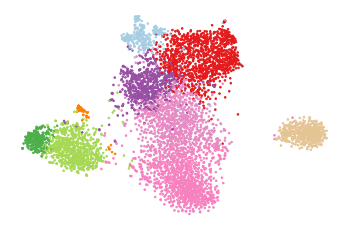

In [7]:
plt.scatter(ad.obsm['X_tsne'][:, 0], ad.obsm['X_tsne'][:, 1],
           s=3, color=colors[ad.obs['clusters']])
ax = plt.gca()
ax.set_axis_off()

### Pseudotime

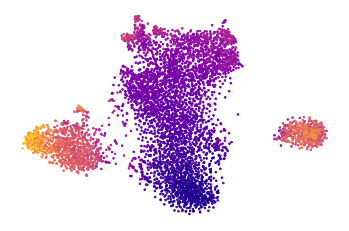

In [8]:
plt.scatter(ad.obsm['X_tsne'][:, 0], ad.obsm['X_tsne'][:, 1],
           s=3, c=ad.obs['dpt_pseudotime'], cmap=matplotlib.cm.plasma)
ax = plt.gca()
ax.set_axis_off()

### Branches

Branches identified by DPT

In [9]:
branches = ad.obs['dpt_groups'].unique()
dpt_colors = pd.Series(sns.color_palette('hls',  len(branches)).as_hex(), 
                       index=branches)

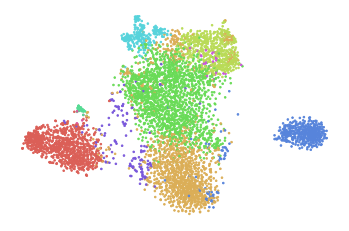

In [13]:
plt.scatter(ad.obsm['X_tsne'][:, 0], ad.obsm['X_tsne'][:, 1],
           s=3, color=dpt_colors[ad.obs['dpt_groups'].values])
ax = plt.gca()
ax.set_axis_off()

### Trends

In [14]:
genes = ['CD34', 'MPO', 'IRF8', 'CD79A', 'GATA1', 'ITGA2B'] + \
    ['CD34', 'SPI1', 'MPO', 'GATA1', 'IRF8', 'CD79B', 'CEBPG', 'CSF1R']
genes = list(set(genes))

In [15]:
trends = pd.Series()

    generating colors for dpt_groups using palette


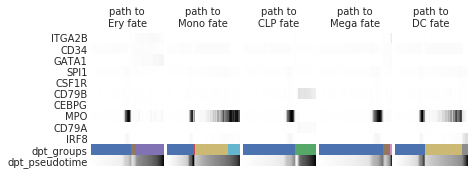

In [16]:
paths = [('Ery', [0, 5, 4]),  # use the category indices instead of the cluster names
         ('Mono', [0, 3, 8, 9]), 
         ('CLP', [0, 2]),
         ('Mega', [0, 5, 6]),
         ('DC', [0, 3, 8, 7])]

_, axs = plt.subplots(ncols=len(paths), figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.11})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        ad, path, genes,                         
        show_node_names=False,
        groups_key='dpt_groups',
        ax=axs[ipath],
        n_avg=50,
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',                             
        title='path to\n{} fate'.format(descr),
        return_data=True,
        show=False)
    trends[descr] = data

In [17]:
from matplotlib.ticker import FormatStrFormatter

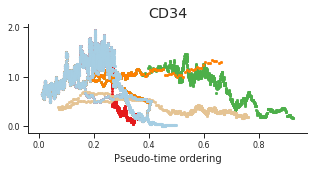

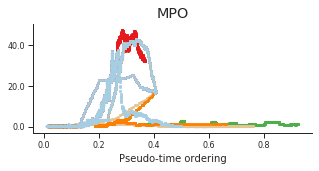

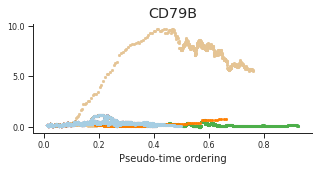

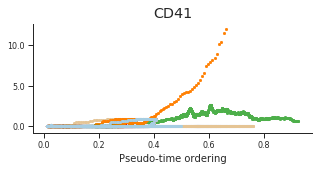

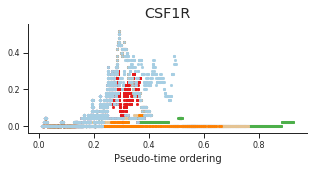

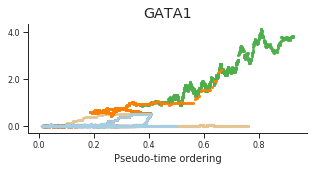

In [18]:
genes = ['CD34', 'MPO',  'CD79B', 'ITGA2B', 'CSF1R', 'GATA1']
labels = ['CD34', 'MPO', 'CD79B', 'CD41', 'CSF1R', 'GATA1']

for gene, label in zip(genes, labels):
    fig = plt.figure(figsize=[5, 2])

    ax = plt.gca()

    for l in trends.keys():
        order = trends[l].distance.sort_values().index
    
        bins = np.ravel(trends[l].distance[order])
        t = np.ravel(trends[l].loc[order, gene])

        # Plot
        plt.scatter(bins, t, color=ct_colors[l], s=5)


    ax.set_title(label)
    ax.set_xlabel('Pseudo-time ordering', fontsize=10)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    sns.despine()
    